In [35]:
# 1. Import Libraries and Setup Environment 

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from minisom import MiniSom  

# Use a plot style for prettier graphs
plt.style.use('fivethirtyeight')

In [36]:
# 2. Import Data
DATA_DIR = 'Mall_Customers.csv'
df = pd.read_csv(DATA_DIR)

print("Dataset preview:")
df

Dataset preview:


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [37]:
# 3. Data Cleaning & Feature Selection

# Check for missing values (if any)
print("Missing values in each column:")
print(df.isnull().sum())

# Select only the two features we want to use:
# Annual Income (k$) and Spending Score (1-100)
features = df[['Annual Income (k$)', 'Spending Score (1-100)']]
data = features.values
print("\nData shape:", data.shape)

Missing values in each column:
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

Data shape: (200, 2)


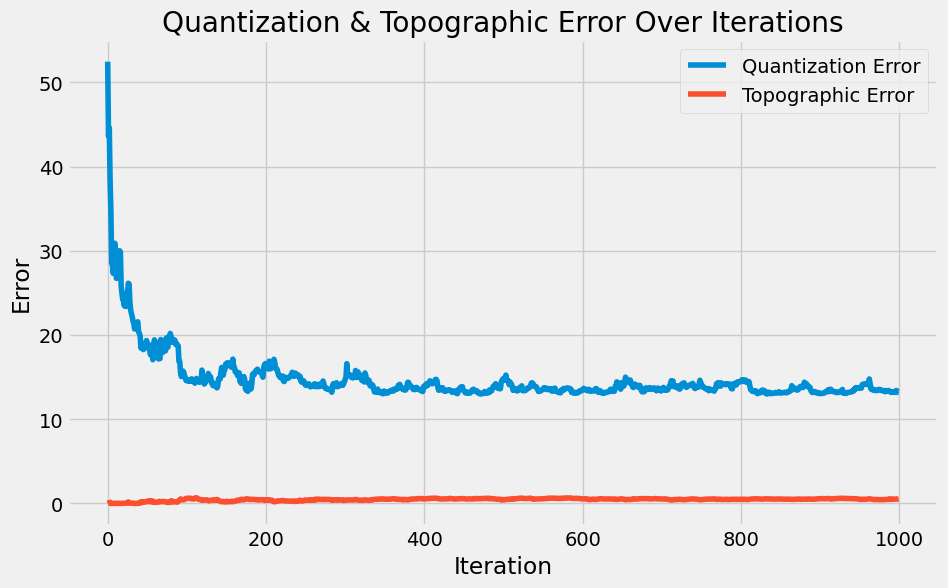

In [38]:
# 4. Train the Self-Organizing Map (SOM)
# Here we create a linear SOM (1 x 5) where each neuron represents one potential customer cluster.
# Quantization Error" measures the average distance between each data point and its best matching unit (BMU - best matching unit ).
# Topographic Error evaluates how well the SOM preserves the data's topological structure.
som_shape = (1, 5)  # 1 row and 5 columns = 5 neurons/clusters
som = MiniSom(som_shape[0], som_shape[1], data.shape[1], sigma=0.5, learning_rate=0.5)

max_iter = 1000           # Total number of training iterations
q_error = []              # List to store quantization error values
t_error = []              # List to store topographic error values

# Train the SOM and compute errors in each iteration
for i in range(max_iter):
    # Pick a random sample from the data
    rand_i = np.random.randint(len(data)) y
    # Update weights based on the chosen data point
    som.update(data[rand_i], som.winner(data[rand_i]), i, max_iter)
    # Compute and record the quantization and topographic errors on the dataset
    q_error.append(som.quantization_error(data))
    t_error.append(som.topographic_error(data))

# Plot the quantization error and topographic error over iterations.
plt.figure(figsize=(10,6))
plt.plot(np.arange(max_iter), q_error, label='Quantization Error')
plt.plot(np.arange(max_iter), t_error, label='Topographic Error')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Quantization & Topographic Error Over Iterations')
plt.legend()
plt.show()

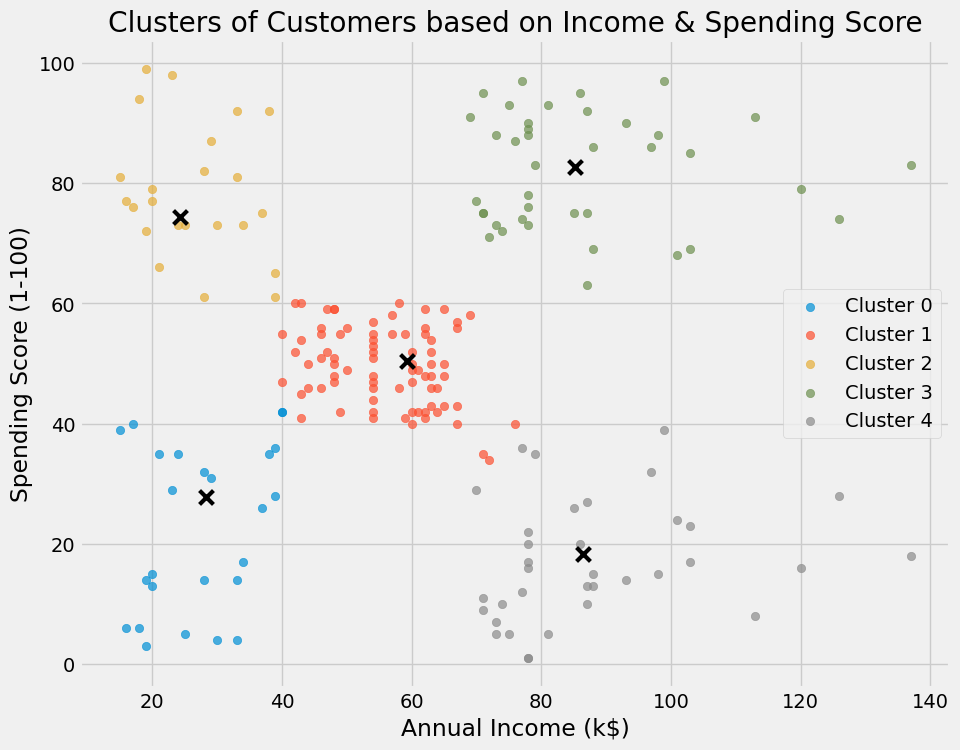

Cluster composition (number of customers per cluster):
Cluster 0: 25 customers
Cluster 1: 78 customers
Cluster 2: 23 customers
Cluster 3: 39 customers
Cluster 4: 35 customers


In [39]:
# 5. Cluster Visualization
# We now assign each data point to a cluster by finding its Best Matching Unit (BMU) on the SOM grid.
# Since our SOM has a shape of (1,5), each neuron corresponds to a cluster.

# Find the BMU coordinates for each data point.
winner_coordinates = np.array([som.winner(x) for x in data]).T

# Convert the 2D coordinates of the neurons into a one-dimensional cluster index.
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

# Plot clusters and centroids
plt.figure(figsize=(10,8))
unique_clusters = np.unique(cluster_index)
for c in unique_clusters:
    plt.scatter(data[cluster_index == c, 0],
                data[cluster_index == c, 1], 
                label='Cluster ' + str(c), alpha=0.7)
    
# Plot the centroids using the SOM's weights.
weights = som.get_weights()
for i in range(som_shape[0]):
    for j in range(som_shape[1]):
        plt.scatter(weights[i][j][0],
                    weights[i][j][1], 
                    marker='x', s=100, linewidths=3, color='k')



plt.title("Clusters of Customers based on Income & Spending Score")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.legend(loc='best')
plt.show()

# Display cluster composition
print("Cluster composition (number of customers per cluster):")
unique, counts = np.unique(cluster_index, return_counts=True)
for cl, cnt in zip(unique, counts):
    print(f"Cluster {cl}: {cnt} customers")

In [40]:
# Compute mean income and spending for each cluster
cluster_stats = []
for c in np.unique(cluster_index):
    cluster_data = data[cluster_index == c]
    income_avg = cluster_data[:, 0].mean()
    spend_avg = cluster_data[:, 1].mean()
    cluster_stats.append((c, income_avg, spend_avg))

# Define basic rules for interpreting clusters
def describe_cluster(c_id, income, spending):
    if income < 40 and spending < 40:
        return f"Cluster {c_id}: Low income and low spending score – customers with less spending power."
    elif income < 40 and spending >= 60:
        return f"Cluster {c_id}: Low income but high spending score – budget customers with active spending."
    elif income >= 70 and spending >= 60:
        return f"Cluster {c_id}: High income with high spending score – premium customers who actively spend."
    elif income >= 70 and spending < 40:
        return f"Cluster {c_id}: High income but low spending score – affluent customers who tend to spend cautiously."
    else:
        return f"Cluster {c_id}: Medium income and medium spending score – average shoppers."

# Print dynamic interpretations
print("Customer Segment Interpretations:\n")
for cid, inc, spd in sorted(cluster_stats, key=lambda x: x[0]):  # Sort by cluster ID
    print(describe_cluster(cid, inc, spd))


Customer Segment Interpretations:

Cluster 0: Low income and low spending score – customers with less spending power.
Cluster 1: Medium income and medium spending score – average shoppers.
Cluster 2: Low income but high spending score – budget customers with active spending.
Cluster 3: High income with high spending score – premium customers who actively spend.
Cluster 4: High income but low spending score – affluent customers who tend to spend cautiously.
